In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import yfinance as yf
import datetime as dt
import statsmodels as sm
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import ADX, rsi, MACD, slope, ATR, get_last_date

plt.style.use(['science','notebook','grid'])
#plt.style.available

In [2]:
# Insert Start Date Here
startdate = '2020-1-1'

# Insert Stock Tickers Here
#tickers=['^BVSP','VALE3.SA','VIIA3.SA','PETR4.SA','BBDC4.SA','ITUB4.SA','MGLU3.SA','COGN3.SA','B3SA3.SA','BBAS3.SA','IRBR3.SA','ABEV3.SA','OIBR3.SA','AZUL4.SA','CIEL3.SA','PETR3.SA','JBSS3.SA','BPAC11.SA','RENT3.SA','ITSA4.SA','WEGE3.SA','LREN3.SA','SUZB3.SA','GGBR4.SA','GOLL4.SA','SBSP3.SA','BRFS3.SA','CYRE3.SA','RAIL3.SA','EQTL3.SA','RADL3.SA','MRFG3.SA','USIM5.SA','SULA11.SA','BRML3.SA','CSNA3.SA','HYPE3.SA','KLBN11.SA','PRIO3.SA','PCAR3.SA','CSAN3.SA','CVCB3.SA','CRFB3.SA','MULT3.SA','BBSE3.SA','UGPA3.SA','HAPV3.SA','TOTS3.SA','QUAL3.SA','GOAU4.SA','JHSF3.SA','CCRO3.SA','EZTC3.SA','CMIG4.SA','EMBR3.SA','SANB11.SA','YDUQ3.SA','ELET6.SA','BEEF3.SA','BRAP4.SA','MRVE3.SA','CPFE3.SA','EGIE3.SA','ENEV3.SA','BRKM5.SA','ECOR3.SA','TAEE11.SA','SAPR11.SA','MEAL3.SA','FLRY3.SA','LCAM3.SA','ALPA4.SA','GFSA3.SA','AMAR3.SA','MOVI3.SA','LIGT3.SA','ALSO3.SA','PSSA3.SA','ENBR3.SA','EVEN3.SA','TEND3.SA','MDIA3.SA','VIVA3.SA','BIDI11.SA','RAPT4.SA','TRPL4.SA','POMO4.SA','BRSR6.SA','SMTO3.SA','ARZZ3.SA','MYPK3.SA','BRPR3.SA','SLCE3.SA','TCSA3.SA','TRIS3.SA','DIRR3.SA','GUAR3.SA','POSI3.SA','CMIG3.SA','SQIA3.SA','CPLE6.SA','ENGI11.SA','NTCO3.SA','ALUP11.SA','VIVT3.SA','ANIM3.SA','BKBR3.SA','BMGB4.SA','CAML3.SA','CEAB3.SA','CSMG3.SA','DMMO3.SA','ENAT3.SA','GRND3.SA','HBOR3.SA','LEVE3.SA','LJQQ3.SA','LOGG3.SA','LOGN3.SA','LPSB3.SA','LWSA3.SA','MILS3.SA','MTRE3.SA','ODPV3.SA','PARD3.SA','PTBL3.SA','RCSL4.SA','ROMI3.SA','UNIP6.SA','WIZS3.SA','SIMH3.SA','SEER3.SA','TASA4.SA','TGMA3.SA','DMVF3.SA','AALR3.SA','PRNR3.SA','APER3.SA','FRAS3.SA']
tickers=['VALE3.SA','PETR4.SA','BBDC4.SA','ITUB4.SA']

In [3]:
%%time

sec_data_final = pd.DataFrame()

len_tickers = len(tickers)
estimated_time = len(tickers)*10/60

fails = 0
success = 0
fail_list = []

print("Estimated Time: {:.0f} minutes for {} tickers".format(estimated_time, len_tickers))
print("+++ Data Load Started +++")

for t in tickers: 
    try:
            sec_data = pd.DataFrame()
            sec_data = wb.DataReader(t, data_source='yahoo', start = startdate)#,session=session)
            sec_data.reset_index(level=0, inplace=True)
            
            sec_data['LastPrice'] = sec_data['Adj Close'].shift(1)
            
            sec_data['PctReturn'] = ( sec_data['Adj Close']/sec_data['LastPrice'] )-1
            
            sec_data['LogReturn'] = np.log(sec_data['Adj Close'] / sec_data['Adj Close'].shift(1))
            
            sec_data['Body'] = abs(sec_data['Adj Close']-sec_data['Open'])
            sec_data['Shadow_Lower'] = np.where(sec_data['Adj Close']>=sec_data['Open'],sec_data['Open']-sec_data['Low'],sec_data['Adj Close']-sec_data['Low'] )
            sec_data['Shadow_Upper'] = np.where(sec_data['Adj Close']>=sec_data['Open'],sec_data['High']-sec_data['Adj Close'],sec_data['High']-sec_data['Open'] )
            
            sec_data['Body_Relative'] = (abs(sec_data['Adj Close']-sec_data['Open'])/(abs(sec_data['Adj Close']+sec_data['Open'])/2))
            
            sec_data['Shadow_Lower_Relative'] = sec_data['Shadow_Lower']/sec_data['Body']
            sec_data['Shadow_Upper_Relative'] = sec_data['Shadow_Upper']/sec_data['Body']
            sec_data['Volatility_Anual'] = sec_data['LogReturn'].rolling(window=252).std()*np.sqrt(252)
            sec_data['Volatility_Month'] = sec_data['LogReturn'].rolling(window=21).std()*np.sqrt(252)      
            
            sec_data['Last_Returns_10'] = sec_data['LogReturn'].rolling(window=10).sum()
                        
            sec_data['Trend5'] = slope(sec_data['Adj Close'],5)
            sec_data['Trend9'] = slope(sec_data['Adj Close'],9)
            sec_data['Trend14'] = slope(sec_data['Adj Close'],14)
            sec_data['Trend20'] = slope(sec_data['Adj Close'],20)
            
            sec_data['Momentum_10'] = sec_data['Adj Close']-sec_data['Adj Close'].shift(9)  
            sec_data['Momentum_10_SMA_9'] = sec_data['Momentum_10'].rolling(window=9).mean()
            
            sec_data['OBVsign'] = np.where(sec_data['Adj Close']<sec_data['LastPrice'],-1,1)*sec_data['Volume']
            sec_data['OBV'] = sec_data['OBVsign'].cumsum()
            
            sec_data['OBV_Trend5'] = slope(sec_data['OBV'],5)
            sec_data['OBV_Trend14'] = slope(sec_data['OBV'],14)
            
            sec_data['ADX14'] = ADX(sec_data,14) 
            sec_data['ADX14_Trend5'] = slope(sec_data['ADX14'],5)
            sec_data['ADX14_Trend14'] = slope(sec_data['ADX14'],14)
            
            sec_data['ATR14'] = ATR(sec_data,14)['ATR']
            sec_data['ATR14_Trend5'] = slope(sec_data['ATR14'],5)
            sec_data['ATR14_Trend14'] = slope(sec_data['ATR14'],14)      
            
             
            sec_data['SMA3'] = sec_data['Adj Close'].rolling(window=3).mean()                            
            sec_data['SMA8'] = sec_data['Adj Close'].rolling(window=8).mean()
            sec_data['SMA20'] = sec_data['Adj Close'].rolling(window=20).mean()
            sec_data['SMA20_STD'] = sec_data['Adj Close'].rolling(window=20).std()
            sec_data['SMA200'] = sec_data['Adj Close'].rolling(window=200).mean()            
                     
            sec_data['Bollinger_Sup'] = sec_data['SMA20']+2*sec_data['SMA20_STD']
            sec_data['Bollinger_Inf'] = sec_data['SMA20']-2*sec_data['SMA20_STD']
            
            sec_data['Bollinger_Sup%'] = (sec_data['Adj Close']-sec_data['Bollinger_Sup'])/sec_data['Adj Close']
            sec_data['Bollinger_Inf%'] = (sec_data['Adj Close']-sec_data['Bollinger_Inf'])/sec_data['Adj Close']
            
            sec_data['Bollinger_Spread'] = (sec_data['Bollinger_Sup']-sec_data['Bollinger_Inf'])/sec_data['SMA20']
            sec_data['Bollinger_Spread_Trend5'] = slope(sec_data['Bollinger_Spread'],5)
            sec_data['Bollinger_Spread_Trend14'] = slope(sec_data['Bollinger_Spread'],14)
            
            sec_data['IFR_2'] = rsi(sec_data,2)
            sec_data['IFR'] = rsi(sec_data,9)
            
            sec_data['IFR_Trend5'] = slope(sec_data['IFR'],5)
            sec_data['IFR_Trend14'] = slope(sec_data['IFR'],14)
            
            sec_data['EMA9'] = sec_data['Adj Close'].ewm(span=9,adjust=False).mean()
            sec_data['EMA9%'] = (sec_data['Adj Close']-sec_data['EMA9'])/sec_data['Adj Close']
            
            sec_data['EMA9_Trend9'] = slope(sec_data['EMA9'],9)
            
            sec_data['EMA12'] = sec_data['Adj Close'].ewm(span=12,adjust=False).mean()
            sec_data['EMA21'] = sec_data['Adj Close'].ewm(span=21,adjust=False).mean()
            sec_data['EMA21%'] = (sec_data['Adj Close']-sec_data['EMA21'])/sec_data['Adj Close']
            sec_data['EMA26'] = sec_data['Adj Close'].ewm(span=26,adjust=False).mean()
            
            sec_data['EMA50'] = sec_data['Adj Close'].ewm(span=50,adjust=False).mean()
            sec_data['EMA50%'] = (sec_data['Adj Close']-sec_data['EMA50'])/sec_data['Adj Close']
            
            sec_data['EMA50_Trend14'] = slope(sec_data['EMA50'],14)
                        
            sec_data['EMA200'] = sec_data['Adj Close'].ewm(span=200,adjust=False).mean()
            sec_data['EMA200%'] = (sec_data['Adj Close']-sec_data['EMA200'])/sec_data['Adj Close']
            
            sec_data['MACD'] = sec_data['EMA12']-sec_data['EMA26']
            sec_data['MACD_Signal'] =  sec_data['MACD'].ewm(span=9,adjust=False).mean()
            sec_data['MACD_Hist'] = sec_data['MACD'] - sec_data['MACD_Signal']          
            
            sec_data['MACD_Hist_Trend5'] = slope(sec_data['MACD_Hist'],5)
            sec_data['MACD_Hist_Trend14'] = slope(sec_data['MACD_Hist'],14)
                       
            sec_data['SMA9_VOLUME'] = sec_data['Volume'].rolling(window=9).mean()
            sec_data['SMA20_VOLUME'] = sec_data['Volume'].rolling(window=20).mean()
            sec_data['SMA200_VOLUME'] = sec_data['Volume'].rolling(window=200).mean()
            
            sec_data['SMA9_VOLUME%'] = (sec_data['Volume']/sec_data['SMA9_VOLUME']) - 1
            sec_data['SMA20_VOLUME%'] = (sec_data['Volume']/sec_data['SMA20_VOLUME']) - 1
            
            sec_data['STOCHASTIC_K_FAST'] = 100 * (sec_data['Adj Close'] - sec_data['Low'].rolling( window = 14 ).min())/(sec_data['High'].rolling( window = 14 ).max() - sec_data['Low'].rolling( window = 14 ).min())
            sec_data['STOCHASTIC_D_FAST'] = sec_data['STOCHASTIC_K_FAST'].rolling(window = 3).mean()
            
            sec_data['STOCHASTIC_K_SLOW'] = sec_data['STOCHASTIC_D_FAST']
            sec_data['STOCHASTIC_D_SLOW'] = sec_data['STOCHASTIC_K_SLOW'].rolling(window = 3).mean()
            
            sec_data['STO_Trend5'] = slope(sec_data['STOCHASTIC_D_SLOW'],5)
            sec_data['STO_Trend14'] = slope(sec_data['STOCHASTIC_D_SLOW'],14)
            
            #### SETUPS ###############################################################################
            
            sec_data['#Romp_EMA9_Bear'] = np.where((sec_data['EMA9_Trend9']>2) & (sec_data['Adj Close']<sec_data['EMA9']),1,0)
            sec_data['#Romp_EMA9_Bull'] = np.where((sec_data['EMA9_Trend9']<-2) & (sec_data['Adj Close']>sec_data['EMA9']),1,0)
            sec_data['#Romp_EMA9'] = sec_data['#Romp_EMA9_Bear'] + sec_data['#Romp_EMA9_Bull']
            
            sec_data['#Romp_EMA50_Bear'] = np.where((sec_data['EMA50_Trend14']>2) & (sec_data['Adj Close']<sec_data['EMA50']),1,0)
            sec_data['#Romp_EMA50_Bull'] = np.where((sec_data['EMA50_Trend14']<-2) & (sec_data['Adj Close']>sec_data['EMA50']),1,0)
            sec_data['#Romp_EMA50'] = sec_data['#Romp_EMA50_Bear'] + sec_data['#Romp_EMA50_Bull']
            
            sec_data['#MACDH_Change_Bear'] = np.where((sec_data['MACD_Hist'].shift(1)>0)&(sec_data['MACD_Hist']<0),-1,0)
            sec_data['#MACDH_Change_Bull'] = np.where((sec_data['MACD_Hist'].shift(1)<0)&(sec_data['MACD_Hist']>0),1,0) 
            sec_data['#MACDH_Change'] =  sec_data['#MACDH_Change_Bear'] + sec_data['#MACDH_Change_Bull']
            
            sec_data['#EMA9_Change_Bear'] = np.where((sec_data['EMA9_Trend9']>0)&(sec_data['EMA9']<sec_data['EMA9'].shift(1)),-1,0)
            sec_data['#EMA9_Change_Bull'] = np.where((sec_data['EMA9_Trend9']<0)&(sec_data['EMA9']>sec_data['EMA9'].shift(1)),1,0)
            sec_data['#EMA9_Change'] = sec_data['#EMA9_Change_Bear'] + sec_data['#EMA9_Change_Bull']
            
            sec_data['#Trend_Divergence_Bear'] =  np.where((sec_data['Trend5']>0) & (sec_data['IFR_Trend5']<0) & (sec_data['OBV_Trend5']<0),-1,0)
            sec_data['#Trend_Divergence_Bull'] =  np.where((sec_data['Trend5']<0)& (sec_data['IFR_Trend5']>0) & (sec_data['OBV_Trend5']>0),1,0)
            sec_data['#Trend_Divergence'] = sec_data['#Trend_Divergence_Bear']+sec_data['#Trend_Divergence_Bull']
            
            sec_data['#IFR2_Bear'] = np.where((sec_data['EMA9_Trend9']<-2)&(sec_data['IFR_2']>90),1,0)
            sec_data['#IFR2_Bull'] = np.where((sec_data['EMA9_Trend9']>2)&(sec_data['IFR_2']<10),1,0)
            sec_data['#IFR2'] = sec_data['#IFR2_Bear'] + sec_data['#IFR2_Bull']
            
            sec_data['#AGULHADA'] = np.where( 
                (sec_data['SMA3']>sec_data['SMA8']) & 
                (sec_data['SMA8']>sec_data['SMA20']) & 
                (sec_data['SMA20'].shift(2) > sec_data['SMA8'].shift(2)) &
                (sec_data['SMA8'].shift(2) > sec_data['SMA3'].shift(2)),1,0)
            
            sec_data['#INSIDEBAR_Bull'] = np.where(
                (sec_data['Adj Close']<sec_data['Adj Close'].shift(1))&
                (sec_data['Adj Close']>sec_data['Open'].shift(1))&
                (sec_data['High']<sec_data['High'].shift(1))&
                (sec_data['Low']>sec_data['Low'].shift(1))&
                (sec_data['Open']>sec_data['Open'].shift(1))&
                (sec_data['Open']<sec_data['Adj Close'].shift(1)),1,0)
            
            sec_data['#INSIDEBAR_Bear'] = np.where(
                (sec_data['Adj Close']>sec_data['Adj Close'].shift(1))&
                (sec_data['Adj Close']<sec_data['Open'].shift(1))&
                (sec_data['High']<sec_data['High'].shift(1))&
                (sec_data['Low']>sec_data['Low'].shift(1))&
                (sec_data['Open']<sec_data['Open'].shift(1))&
                (sec_data['Open']>sec_data['Adj Close'].shift(1)),1,0)
            
            sec_data['#INSIDEBAR'] = sec_data['#INSIDEBAR_Bull'] + sec_data['#INSIDEBAR_Bear']
                        
            sec_data['Stock'] = t[:-3]
            
            sec_data_final = pd.concat([sec_data_final,sec_data])
            
            ##############################################################################
            
            success = success + 1
            left_to_load = len_tickers - success - fails
            time_left = left_to_load*10/60
            completion = (fails+success)/len(tickers)
            
            print('+++ Data Load Complete for {}___{:.2%}____{:.1f} minutes left'.format(t,completion,time_left))      
          
    except Exception as e: 
            fails = fails + 1
            fail_list.append(t)
            print("--- ", e)

    
print('\nSuccessful Loads: {}  Failed: {}'.format(success,fails))
print("List of Fails:", fail_list)  


Estimated Time: 1 minutes for 4 tickers
+++ Data Load Started +++
+++ Data Load Complete for VALE3.SA___25.00%____0.5 minutes left
+++ Data Load Complete for PETR4.SA___50.00%____0.3 minutes left
+++ Data Load Complete for BBDC4.SA___75.00%____0.2 minutes left
+++ Data Load Complete for ITUB4.SA___100.00%____0.0 minutes left

Successful Loads: 4  Failed: 0
List of Fails: []
Wall time: 23 s


In [4]:
#pd.set_option('display.max_columns', None)
#sec_data_final

sec_last_date = get_last_date(sec_data_final)

sec_last_date.to_csv('..\\sheets\\bovespa_diario_last_date.csv', sep =';', index=False)

sec_last_date

,Date,High,Low,Open,Close,Volume,Adj Close,LastPrice,PctReturn,LogReturn,...,#Trend_Divergence_Bull,#Trend_Divergence,#IFR2_Bear,#IFR2_Bull,#IFR2,#AGULHADA,#INSIDEBAR_Bull,#INSIDEBAR_Bear,#INSIDEBAR,Stock
590,2022-05-20,82.459999,80.580002,82.010002,81.260002,38372000.0,81.260002,79.849998,0.017658,0.017504,...,0,0,0,0,0,0,0,0,0,VALE3
590,2022-05-20,34.830002,34.250000,34.590000,34.830002,79589900.0,34.830002,34.169998,0.019315,0.019131,...,0,-1,0,0,0,0,0,0,0,PETR4
590,2022-05-20,19.870001,19.530001,19.580000,19.670000,38174000.0,19.670000,19.410000,0.013395,0.013306,...,0,0,0,0,0,0,0,0,0,BBDC4
590,2022-05-20,25.230000,24.850000,25.090000,25.129999,38015900.0,25.129999,24.820000,0.012490,0.012413,...,0,0,0,0,0,0,0,0,0,ITUB4


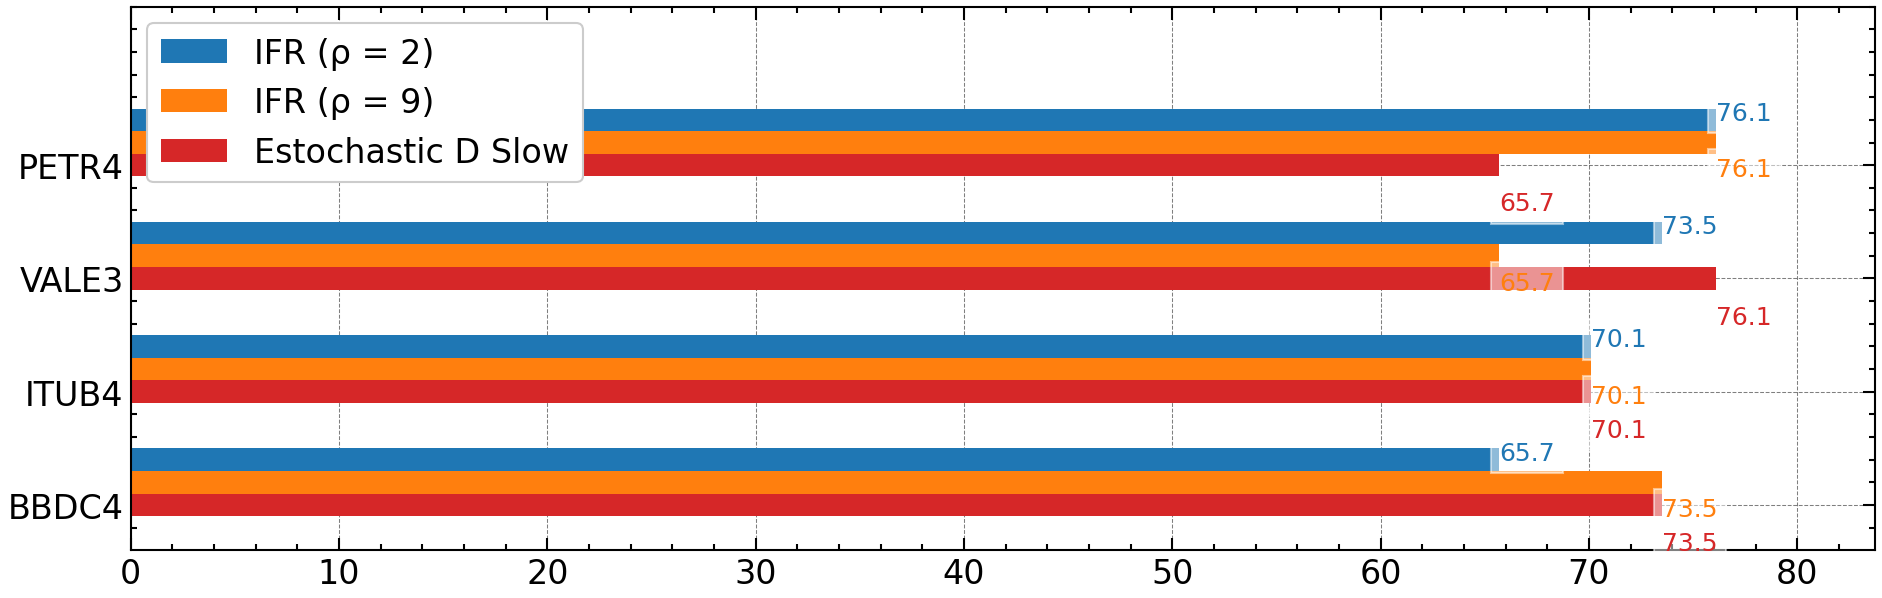

In [5]:
fig, ax = plt.subplots(1,1, figsize=(15,len(tickers)*1.2), dpi=150)
y = sec_last_date.sort_values(by=['IFR_2'],ascending = True)['Stock']
x1 = sec_last_date.sort_values(by=['IFR_2'],ascending = True)['IFR_2'].round(1)
x2 = sec_last_date.sort_values(by=['IFR'],ascending = True)['IFR_2'].round(1)
x3 = sec_last_date.sort_values(by=['STOCHASTIC_D_SLOW'],ascending = True)['IFR_2'].round(1)

ind   = np.arange(len(y))
width = 0.2

ax.barh(ind, x1, width, color='tab:blue',align='center', label='IFR (\u03C1 = 2)')
ax.barh(ind - width, x2, width, color='tab:orange',align='center', label='IFR (\u03C1 = 9)')
ax.barh(ind - 2*width, x3, width, color='tab:red',align='center', label='Estochastic D Slow')

ax.set(yticks = ind - 2*width, yticklabels = y, ylim=[width - 1, len(y)], xlim = [0, sec_last_date.IFR_2.max()*1.1])

ax.legend(loc='upper left')

for i, v in enumerate(x1):
    t =  ax.text(v, i, str(v), fontsize = 12, color='tab:blue')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

for i, v in enumerate(x2):
    t=ax.text(v, i-0.5, str(v), fontsize = 12, color='tab:orange')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    
for i, v in enumerate(x3):
    t=ax.text(v, i-0.8, str(v), fontsize = 12, color='tab:red')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    
plt.show()